In [2]:
%run features_.ipynb
import re
import numpy as np
import pandas as pd
import mne
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
import multiprocessing as mp
from joblib import Parallel, delayed
from pandarallel import pandarallel
from entropy import *
from itertools import combinations, permutations
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import csv
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from mne_features.feature_extraction import extract_features
from mne_features import *
%matplotlib inline

# Parameter

In [3]:
tr_path = "C:/Users/vita7/OneDrive/Documents/Github/EEG_SleepStage_Analysis/data/SC/training_nms/"
te_path = "C:/Users/vita7/OneDrive/Documents/Github/EEG_SleepStage_Analysis/data/SC/testing/"

record_regu = r"SC\d*\D\d\-PSG.edf"
annot_regu = r"SC\d*\D\D\-Hypnogram.edf"

channel_types = {
    'EEG Fpz-Cz': 'eeg',
    'EEG Pz-Oz': 'misc',
    'EOG horizontal': 'misc',
    'Resp oro-nasal': 'misc',
    'EMG submental': 'misc',
    'Temp rectal': 'misc',
    'Event marker': 'misc'
}

sleep_stage = {
    'Sleep stage W': 1,
    'Sleep stage 1': 2,
    'Sleep stage 2': 3,
    'Sleep stage 3': 4,
    'Sleep stage 4': 4,
    'Sleep stage R': 5
}

event_id = {
    'Sleep stage W': 1,
    'Sleep stage 1': 2,
    'Sleep stage 2': 3,
    'Sleep stage 3/4': 4,
    'Sleep stage R': 5,
}

funcs_n = [
    'STD','PermEn','SampEn','AutoCorr'
]
ratio_n = [
    'EEG Fpz-Cz DTR', 'EEG Fpz-Cz DAR', 'EEG Fpz-Cz DSR', 'EEG Fpz-Cz DBR',
    'EEG Fpz-Cz TAR', 'EEG Fpz-Cz TSR', 'EEG Fpz-Cz TBR', 'EEG Fpz-Cz ASR',
    'EEG Fpz-Cz ABR', 'EEG Fpz-Cz SBR'
]
six_bands_n = [
    'EEG Fpz-Cz', 'EEG Fpz-Cz Delta', 'EEG Fpz-Cz Theta', 'EEG Fpz-Cz Alpha',
    'EEG Fpz-Cz Sigma', 'EEG Fpz-Cz Beta'
]
frbands_n = six_bands_n + ratio_n

ep_duration = 10.
sfreq = 100.
chs = 1
funcs = 4
frb = 16

# DataTransfer

### Record name

In [4]:
record_name = []
annot_name = []

events = []  # events
for file_name in os.listdir(tr_path):
    match1 = re.search(record_regu, file_name)
    match2 = re.search(annot_regu, file_name)
    if (match1):
        record_name.append(match1.group())
    elif (match2):
        annot_name.append(match2.group())

if (len(record_name) != len(annot_name)):
    record_name = []
    annot_name = []

df = pd.concat([pd.DataFrame(record_name), pd.DataFrame(annot_name)], axis=1)
df.columns = ['Records', 'Hypnogram']
df

Records               Hypnogram
0  SC4001E0-PSG.edf  SC4001EC-Hypnogram.edf
1  SC4051E0-PSG.edf  SC4051EC-Hypnogram.edf
2  SC4151E0-PSG.edf  SC4151EC-Hypnogram.edf
3  SC4182E0-PSG.edf  SC4182EC-Hypnogram.edf
4  SC4312E0-PSG.edf  SC4312EM-Hypnogram.edf
5  SC4451F0-PSG.edf  SC4451FY-Hypnogram.edf
6  SC4592G0-PSG.edf  SC4592GY-Hypnogram.edf
7  SC4812G0-PSG.edf  SC4812GV-Hypnogram.edf

### Read data

In [5]:
raw_ = []  # raw
events_ = []  # events

for ren, an in zip(record_name, annot_name):
    print('\n\033[5;31;47m File name:\n %s\033[0m\n' % (ren))
    rec = mne.io.read_raw_edf(tr_path + ren, preload=True)
    ann = mne.read_annotations(tr_path + an)

    # set annotations
    rec.set_annotations(ann, emit_warning=True)
    rec.set_channel_types(channel_types)
    rec.filter(0.5, 30, picks=['eeg'])
    ev, _ = mne.events_from_annotations(rec,
                                        use_rounding=False,
                                        event_id=sleep_stage,
                                        chunk_duration=ep_duration)

    events_.append(ev)
    raw_.append(rec)


 File name:
 SC4001E0-PSG.edf

Extracting EDF parameters from C:\Users\vita7\OneDrive\Documents\Github\EEG_SleepStage_Analysis\data\SC\training_nms\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.610 sec)



<ipython-input-5-4c5fbb1b6727>:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rec.set_annotations(ann, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']

 File name:
 SC4051E0-PSG.edf

Extracting EDF parameters from C:\Users\vita7\OneDrive\Documents\Github\EEG_SleepStage_Analysis\data\SC\training_nms\SC4051E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8165999  =      0.000 ... 81659.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.61

<ipython-input-5-4c5fbb1b6727>:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rec.set_annotations(ann, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']

 File name:
 SC4151E0-PSG.edf

Extracting EDF parameters from C:\Users\vita7\OneDrive\Documents\Github\EEG_SleepStage_Analysis\data\SC\training_nms\SC4151E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7859999  =      0.000 ... 78599.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.61

<ipython-input-5-4c5fbb1b6727>:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rec.set_annotations(ann, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']

 File name:
 SC4182E0-PSG.edf

Extracting EDF parameters from C:\Users\vita7\OneDrive\Documents\Github\EEG_SleepStage_Analysis\data\SC\training_nms\SC4182E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8525999  =      0.000 ... 85259.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.61

<ipython-input-5-4c5fbb1b6727>:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rec.set_annotations(ann, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']

 File name:
 SC4312E0-PSG.edf

Extracting EDF parameters from C:\Users\vita7\OneDrive\Documents\Github\EEG_SleepStage_Analysis\data\SC\training_nms\SC4312E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8099999  =      0.000 ... 80999.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.61

<ipython-input-5-4c5fbb1b6727>:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rec.set_annotations(ann, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']

 File name:
 SC4451F0-PSG.edf

Extracting EDF parameters from C:\Users\vita7\OneDrive\Documents\Github\EEG_SleepStage_Analysis\data\SC\training_nms\SC4451F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8369999  =      0.000 ... 83699.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.61

<ipython-input-5-4c5fbb1b6727>:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rec.set_annotations(ann, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']

 File name:
 SC4592G0-PSG.edf

Extracting EDF parameters from C:\Users\vita7\OneDrive\Documents\Github\EEG_SleepStage_Analysis\data\SC\training_nms\SC4592G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6119999  =      0.000 ... 61199.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.61

<ipython-input-5-4c5fbb1b6727>:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rec.set_annotations(ann, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']

 File name:
 SC4812G0-PSG.edf

Extracting EDF parameters from C:\Users\vita7\OneDrive\Documents\Github\EEG_SleepStage_Analysis\data\SC\training_nms\SC4812G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7247999  =      0.000 ... 72479.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.61

<ipython-input-5-4c5fbb1b6727>:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  rec.set_annotations(ann, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


### RAW preprocessing

### RAW visualization

### EP records

In [6]:
epochs_ = []
tmax = ep_duration - 1 / rec.info['sfreq']
for raw, eve in zip(raw_, events_):
    ep = mne.Epochs(
        raw=raw,
        picks=['eeg'],
        events=eve,
        event_id=event_id,
        tmin=0.,
        tmax=tmax,
        baseline=None,  # 1 epoch data - mean ( 1 epoch data)
        detrend=None,  # linear detrend
    )
    epochs_.append(ep)

7950 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
8166 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
7848 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
8526 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
8100 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
8370 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
6120 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
7242 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


### EP Dataframe

In [7]:
ep_df_ = []
for eps in epochs_:
    df = eps.to_data_frame()

    # data balance
    con_len = list(
        df.groupby(level=['condition']).count()['EEG Fpz-Cz'] /
        (ep_duration * sfreq))  # epochs
    drop_len = np.floor(con_len[-1] - np.mean(con_len[:4]))  # epochs
    df = df[int(np.floor(drop_len / 2) *
                (ep_duration * sfreq)):int((np.sum(con_len) -
                                            np.floor(drop_len / 2)) *
                                           (ep_duration * sfreq))]

    # 5 frequency bands
    df['EEG Fpz-Cz Delta'] = mne.filter.filter_data(df['EEG Fpz-Cz'],
                                                    sfreq=100,
                                                    l_freq=0.5,
                                                    h_freq=4.5)
    df['EEG Fpz-Cz Theta'] = mne.filter.filter_data(df['EEG Fpz-Cz'],
                                                    sfreq=100,
                                                    l_freq=4.5,
                                                    h_freq=8.5)
    df['EEG Fpz-Cz Alpha'] = mne.filter.filter_data(df['EEG Fpz-Cz'],
                                                    sfreq=100,
                                                    l_freq=8.5,
                                                    h_freq=11.5)
    df['EEG Fpz-Cz Sigma'] = mne.filter.filter_data(df['EEG Fpz-Cz'],
                                                    sfreq=100,
                                                    l_freq=11.5,
                                                    h_freq=15.5)
    df['EEG Fpz-Cz Beta'] = mne.filter.filter_data(df['EEG Fpz-Cz'],
                                                   sfreq=100,
                                                   l_freq=15.5,
                                                   h_freq=30)

    ep_df_.append(df)

Loading data for 7950 events and 1000 original time points ...
0 bad epochs dropped
Converting "time" to "<class 'numpy.int64'>"...
Setting up band-pass filter from 0.5 - 4.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 4.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Filter length: 661 samples (6.610 sec)

Setting up band-pass filter from 4.5 - 8.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.50
- Lower transition bandwidth: 2.00 Hz (-6 dB 


Loading data for 8526 events and 1000 original time points ...
0 bad epochs dropped
Converting "time" to "<class 'numpy.int64'>"...
Setting up band-pass filter from 0.5 - 4.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 4.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Filter length: 661 samples (6.610 sec)

Setting up band-pass filter from 4.5 - 8.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.50
- Lower transition bandwidth: 2.00 Hz (-6 dB


Loading data for 6120 events and 1000 original time points ...
0 bad epochs dropped
Converting "time" to "<class 'numpy.int64'>"...
Setting up band-pass filter from 0.5 - 4.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 4.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Filter length: 661 samples (6.610 sec)

Setting up band-pass filter from 4.5 - 8.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.50
- Lower transition bandwidth: 2.00 Hz (-6 dB

# Information

In [8]:
for df in ep_df_:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2450000 entries, (Sleep stage W, 2750, 0) to (Sleep stage W, 5199, 9990)
Data columns (total 6 columns):
EEG Fpz-Cz          float64
EEG Fpz-Cz Delta    float64
EEG Fpz-Cz Theta    float64
EEG Fpz-Cz Alpha    float64
EEG Fpz-Cz Sigma    float64
EEG Fpz-Cz Beta     float64
dtypes: float64(6)
memory usage: 123.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1740000 entries, (Sleep stage W, 3213, 0) to (Sleep stage 3/4, 4952, 9990)
Data columns (total 6 columns):
EEG Fpz-Cz          float64
EEG Fpz-Cz Delta    float64
EEG Fpz-Cz Theta    float64
EEG Fpz-Cz Alpha    float64
EEG Fpz-Cz Sigma    float64
EEG Fpz-Cz Beta     float64
dtypes: float64(6)
memory usage: 88.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2926000 entries, (Sleep stage W, 2461, 0) to (Sleep stage W, 5386, 9990)
Data columns (total 6 columns):
EEG Fpz-Cz          float64
EEG Fpz-Cz Delta    float64
EEG Fpz-Cz Theta    float64
EEG Fpz-Cz Alpha  

In [9]:
temp = pd.DataFrame()
for df in ep_df_:
    temp = pd.concat(
        [temp,
         df.groupby(level=['condition']).count()['EEG Fpz-Cz'] / 1000.],
        axis=1)
temp.columns = record_name
temp = temp.T
temp['total'] = np.sum(temp, axis=1)
temp

C:\Users\vita7\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


condition         Sleep stage 1  Sleep stage 2  Sleep stage 3/4  \
SC4001E0-PSG.edf          159.0          750.0            660.0   
SC4051E0-PSG.edf           93.0          405.0            255.0   
SC4151E0-PSG.edf          123.0         1062.0            531.0   
SC4182E0-PSG.edf          453.0          870.0            648.0   
SC4312E0-PSG.edf          374.0          828.0            573.0   
SC4451F0-PSG.edf          459.0          696.0            921.0   
SC4592G0-PSG.edf          270.0          426.0            168.0   
SC4812G0-PSG.edf          204.0          658.0            300.0   

condition         Sleep stage R  Sleep stage W   total  
SC4001E0-PSG.edf          375.0          506.0  2450.0  
SC4051E0-PSG.edf          132.0          855.0  1740.0  
SC4151E0-PSG.edf          624.0          586.0  2926.0  
SC4182E0-PSG.edf          348.0          581.0  2900.0  
SC4312E0-PSG.edf          573.0          908.0  3256.0  
SC4451F0-PSG.edf          336.0         1110.0  3522.0  
SC4592G0-PSG.edf          180.0         1684.0  2728.0  
SC4812G0-PSG.edf          240.0         1318.0  2720.0

In [10]:
ep_df_[0].head()

channel                   EEG Fpz-Cz  EEG Fpz-Cz Delta  EEG Fpz-Cz Theta  \
condition     epoch time                                                   
Sleep stage W 2750  0      -2.577453     -3.552714e-15     -1.332268e-15   
                    10     -3.305230     -2.030010e+00      2.086602e+00   
                    20     -1.259450     -4.103915e+00      3.828182e+00   
                    30     -2.216586     -6.256435e+00      4.944707e+00   
                    40    -12.904394     -8.511535e+00      5.273490e+00   

channel                   EEG Fpz-Cz Alpha  EEG Fpz-Cz Sigma  EEG Fpz-Cz Beta  
condition     epoch time                                                       
Sleep stage W 2750  0        -1.554312e-15      2.664535e-15    -1.776357e-15  
                    10       -7.247862e-02      8.435737e-01    -6.372629e-01  
                    20       -2.277146e-02      7.930517e-01     4.074372e+00  
                    30        1.921674e-01     -2.045970e-01     3.126260e+00  
                    40        4.952914e-01     -1.269419e+00    -6.087737e+00

### Spectrum

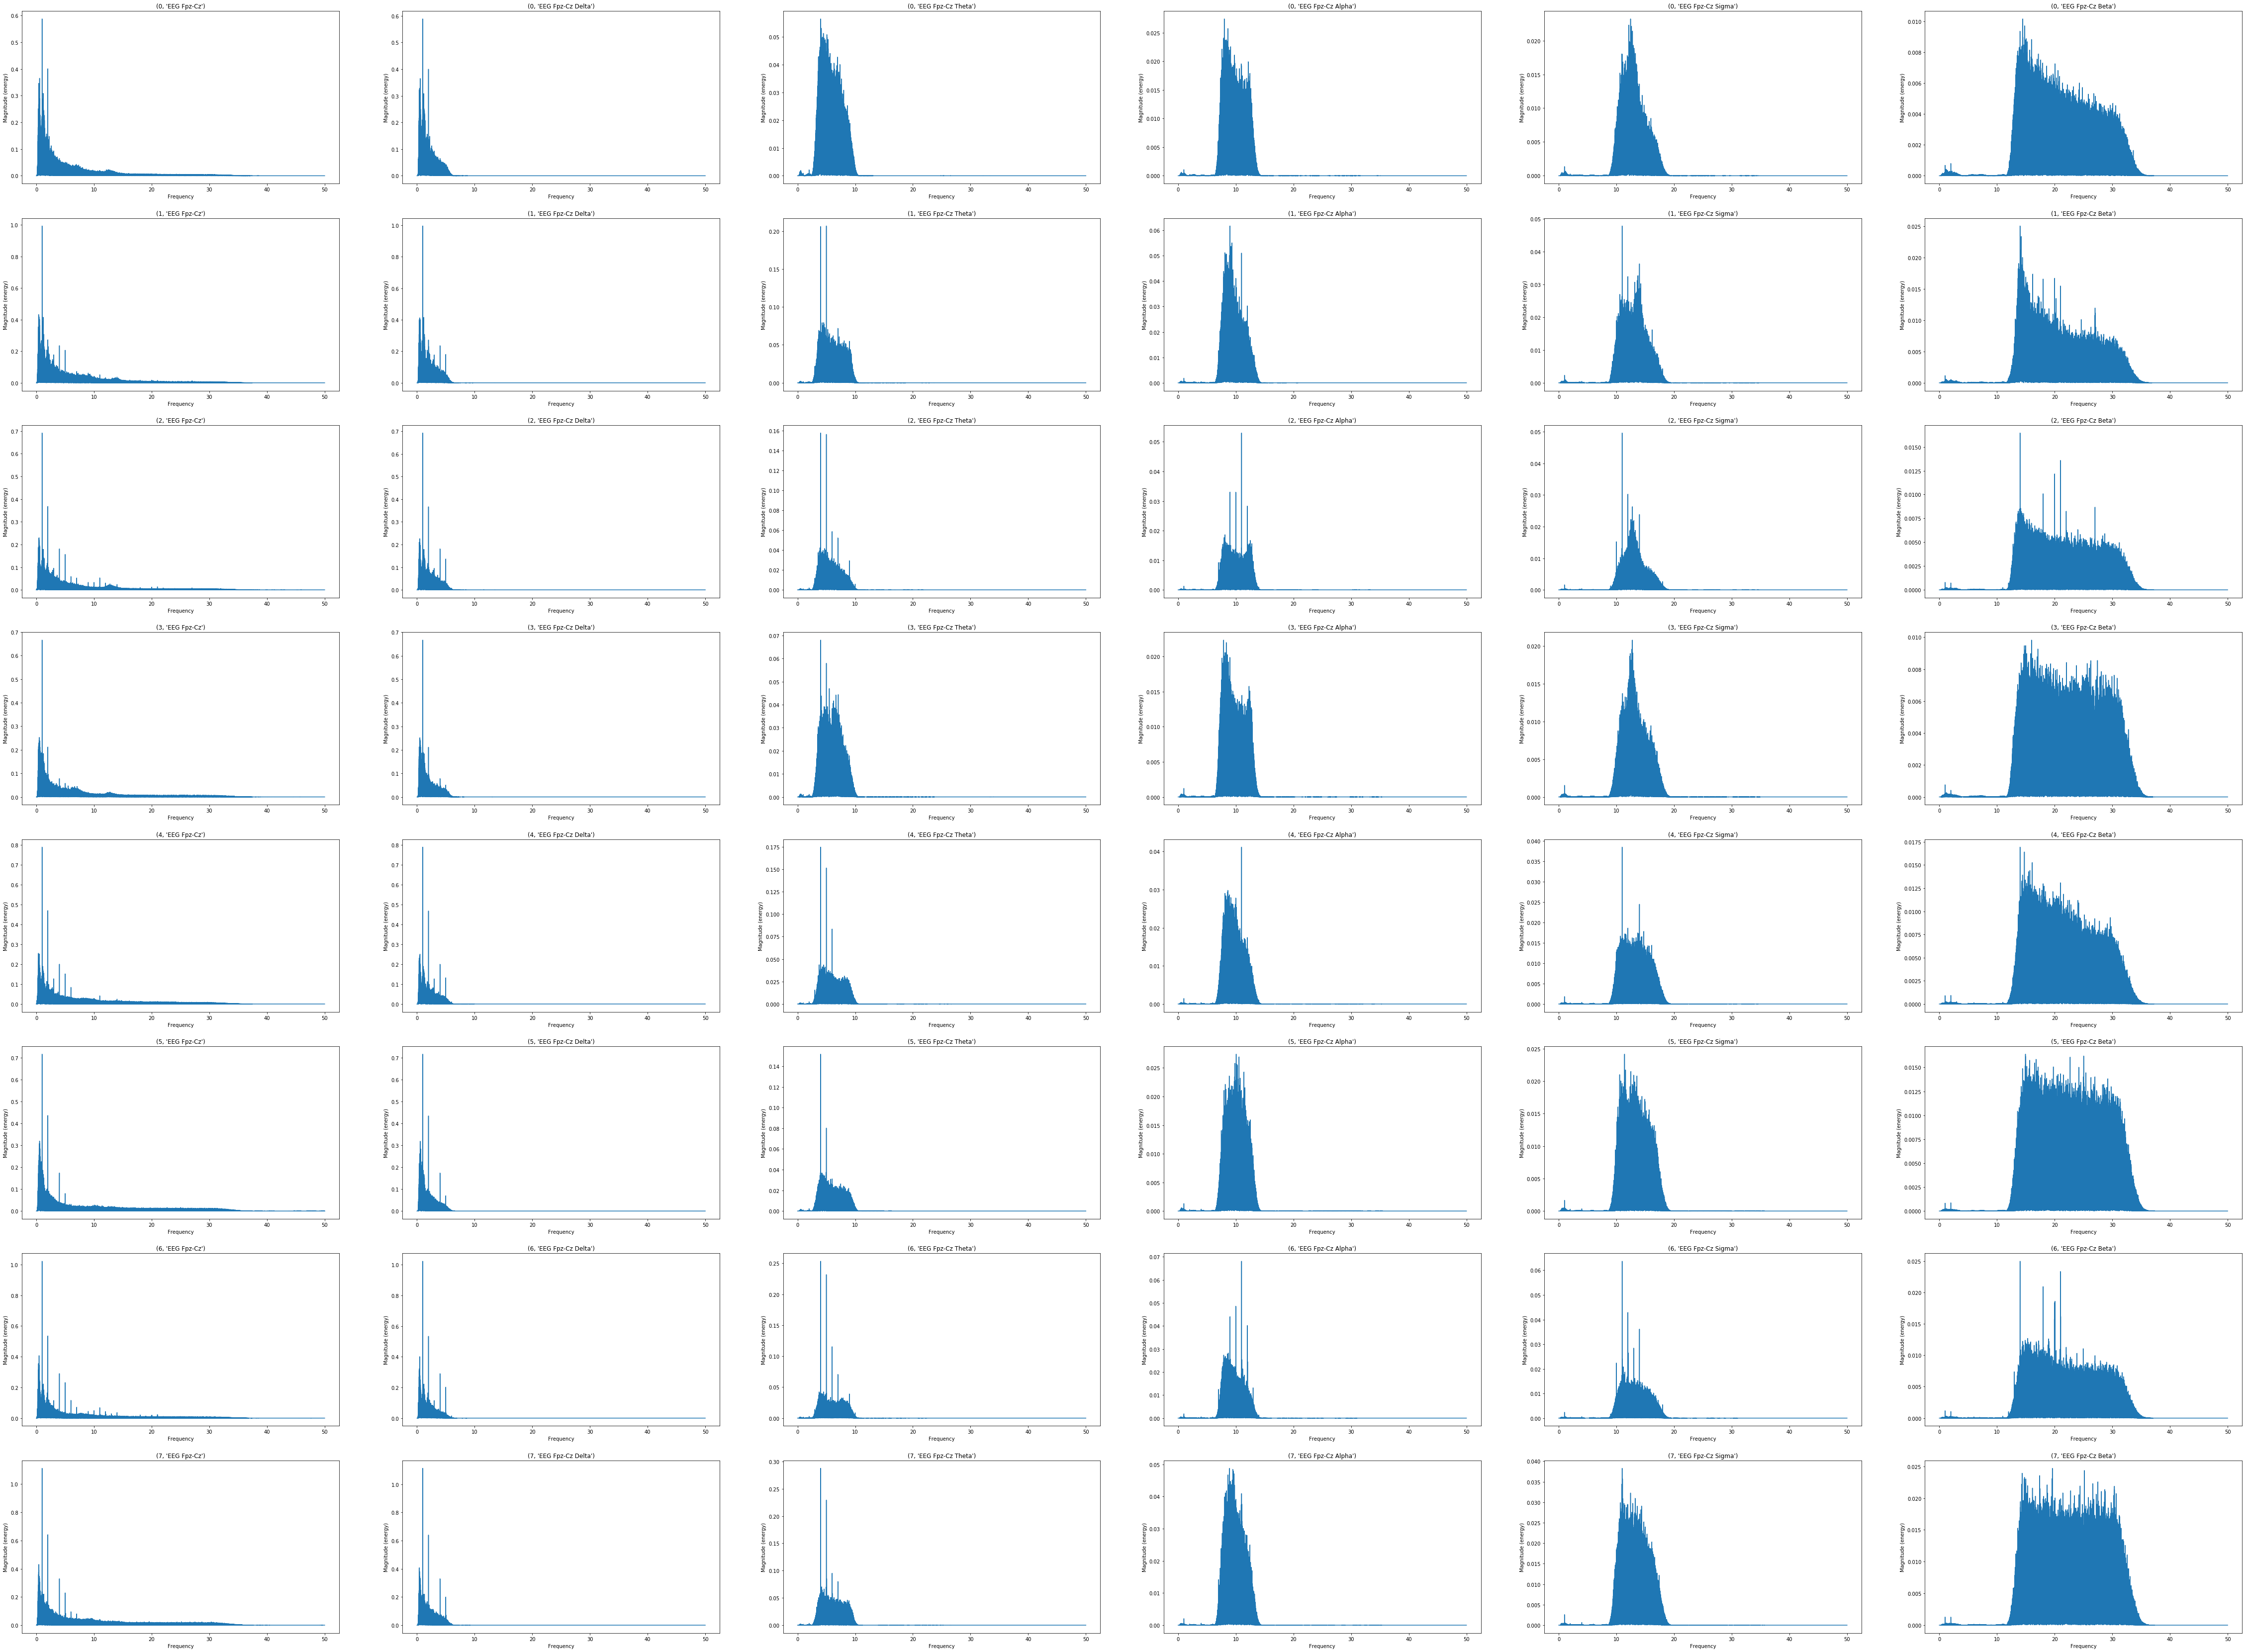

In [11]:
fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(80, 60))

for df, n in zip(ep_df_, range(len(ep_df_))):
    clist = list(df.columns)
    for c in clist:
        axes[n, clist.index(c)].set_title((n, c))
        axes[n, clist.index(c)].magnitude_spectrum(np.array(df[c]), Fs=sfreq)

plt.savefig('Magnitude Spectrum.png')

# Features calculation

In [12]:
# multi processing
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=mp.cpu_count())(delayed(func)(group)
                                             for name, group in dfGrouped)
    return pd.concat(retLst, axis=1).T

In [13]:
def Features_Calculate(df):
    grouped = df.groupby(level=['epoch', 'condition'])
    temps = []
    midx = []

    # multiIndex
    for idx, gr in grouped:
        midx.append(idx)
    midx = pd.MultiIndex.from_tuples(midx, names=('epoch', 'condition'))

    # MNE - Features
    """
    temps.append(
        applyParallel(
            grouped,
            lambda x: pd.Series(univariate.compute_std(x.T.values))).set_index(midx))
    """

    # NUMPY
    """
    # standard
    """
    temps.append(grouped.std())
    """
    temps.append(
        applyParallel(
            grouped,
            lambda x: x.apply(stats.kurtosis, axis=0)).set_index(midx))
    temps.append(
        applyParallel(grouped,
                      lambda x: x.apply(stats.skew, axis=0)).set_index(midx))
    """

    # ENTROPY
    """
    # SpectEn
    temps.append(
        applyParallel(
            grouped, lambda x: x.apply(spectral_entropy,
                                       sf=sfreq,
                                       method='welch',
                                       normalize=True,
                                       axis=0)).set_index(midx))
    """
    # PermEn
    temps.append(
        applyParallel(
            grouped, lambda x: x.apply(perm_entropy, order=3, delay=1, axis=0)
        ).set_index(midx))
    """
    # SVD_En
    temps.append(
        applyParallel(
            grouped, lambda x: x.apply(
                svd_entropy, order=3, delay=1, normalize=True, axis=0)).
        set_index(midx))

    """
    # SampEn
    temps.append(
        applyParallel(
            grouped,
            lambda x: x.apply(sample_entropy, order=2, axis=0)).set_index(
                midx))
    """
    # Petrosian FD
    temps.append(
        applyParallel(grouped,
                      lambda x: x.apply(petrosian_fd, axis=0)).set_index(midx))               

    
    # USER DEF
    """
    temps.append(
        applyParallel(
            grouped, lambda x: x.apply(AutoCorr, k=1, axis=0)).set_index(midx))
    """
    """

    # concat 各種 function
    res = pd.concat(temps, axis=1)
    res.columns = pd.MultiIndex.from_product(iterables=[funcs_n, six_bands_n],
                                             names=['Function', 'Band'])
    return res

In [14]:
temp = []

st = time.time()
for df in ep_df_:
    temp.append(Features_Calculate(df))
tr_df = pd.concat(temp, axis=0)

et = time.time()
print('time-consuming: %f'%(et - st))

time-consuming: 172.602964


In [15]:
tr_df = pd.concat(temp, axis=0)
tr_df.head()

Function                   STD                                    \
Band                EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta   
epoch condition                                                    
2750  Sleep stage W  30.281923        28.821295         8.178119   
2751  Sleep stage W  24.376224        23.349960         7.907419   
2752  Sleep stage W  26.753053        25.842193         7.864009   
2753  Sleep stage W  30.742669        28.715103         8.710937   
2754  Sleep stage W  27.505168        26.253400         8.381343   

Function                                                               \
Band                EEG Fpz-Cz Alpha EEG Fpz-Cz Sigma EEG Fpz-Cz Beta   
epoch condition                                                         
2750  Sleep stage W         3.016133         2.589652        3.532181   
2751  Sleep stage W         2.864568         2.619738        3.676364   
2752  Sleep stage W         2.899630         2.231749        3.238686   
2753  Sleep stage W         3.595037         3.129392        4.860137   
2754  Sleep stage W         2.936017         2.564497        3.691639   

Function                PermEn                                    \
Band                EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta   
epoch condition                                                    
2750  Sleep stage W   2.390395         1.419503         1.668112   
2751  Sleep stage W   2.385801         1.425776         1.634256   
2752  Sleep stage W   2.305821         1.391785         1.680630   
2753  Sleep stage W   2.365200         1.409060         1.682761   
2754  Sleep stage W   2.333510         1.432617         1.649550   

Function                                   ...                 SampEn  \
Band                EEG Fpz-Cz Alpha       ...       EEG Fpz-Cz Theta   
epoch condition                            ...                          
2750  Sleep stage W         1.918959       ...               0.521182   
2751  Sleep stage W         1.932291       ...               0.561431   
2752  Sleep stage W         1.913121       ...               0.560462   
2753  Sleep stage W         1.897981       ...               0.550922   
2754  Sleep stage W         1.925893       ...               0.544342   

Function                                                               \
Band                EEG Fpz-Cz Alpha EEG Fpz-Cz Sigma EEG Fpz-Cz Beta   
epoch condition                                                         
2750  Sleep stage W         0.622485         0.755880        1.617767   
2751  Sleep stage W         0.628287         0.740053        1.534523   
2752  Sleep stage W         0.616738         0.725153        1.486089   
2753  Sleep stage W         0.611738         0.698729        1.196411   
2754  Sleep stage W         0.617204         0.752756        1.635461   

Function              AutoCorr                                    \
Band                EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta   
epoch condition                                                    
2750  Sleep stage W   0.977667         0.994010         0.943813   
2751  Sleep stage W   0.965642         0.991236         0.948917   
2752  Sleep stage W   0.974621         0.991409         0.947258   
2753  Sleep stage W   0.963653         0.991792         0.941834   
2754  Sleep stage W   0.973309         0.993970         0.942251   

Function                                                               
Band                EEG Fpz-Cz Alpha EEG Fpz-Cz Sigma EEG Fpz-Cz Beta  
epoch condition                                                        
2750  Sleep stage W         0.819424         0.669260        0.124444  
2751  Sleep stage W         0.814643         0.666057        0.132910  
2752  Sleep stage W         0.821590         0.679827        0.159802  
2753  Sleep stage W         0.819554         0.663158        0.106962  
2754  Sleep stage W         0.831757         0.645630        0.163811  

[5 rows x 24 columns]

# Preprocessing

### Missing value dection

In [16]:
tr_df.describe().to_csv('des_0.csv')
tr_df.describe()

Function           STD                                                     \
Band        EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta EEG Fpz-Cz Alpha   
count     22242.000000     22242.000000     22242.000000     22242.000000   
mean         18.278106        16.528503         5.614590         3.307348   
std           9.538388         9.483784         2.060198         1.465339   
min           3.799240         2.623069         1.795673         0.920774   
25%          10.866691         8.938891         4.202462         2.330844   
50%          16.050681        14.381258         5.214168         2.930359   
75%          23.878704        22.339410         6.648762         3.863994   
max          92.540796        90.157018        23.223345        22.885056   

Function                                         PermEn                   \
Band     EEG Fpz-Cz Sigma EEG Fpz-Cz Beta    EEG Fpz-Cz EEG Fpz-Cz Delta   
count        22242.000000    22242.000000  22242.000000     22242.000000   
mean             2.735894        2.951983      2.230521         1.419747   
std              1.269584        2.253952      0.166176         0.042512   
min              0.722556        0.799036      1.624549         1.176535   
25%              1.916040        1.530512      2.107532         1.393472   
50%              2.468223        2.253706      2.238539         1.424005   
75%              3.313172        3.484458      2.373793         1.449849   
max             26.726390       48.613711      2.529930         1.541556   

Function                                         ...                 SampEn  \
Band     EEG Fpz-Cz Theta EEG Fpz-Cz Alpha       ...       EEG Fpz-Cz Theta   
count        22242.000000     22242.000000       ...           22242.000000   
mean             1.712364         1.929173       ...               0.604327   
std              0.041863         0.028608       ...               0.033581   
min              1.570972         1.779814       ...               0.185194   
25%              1.682779         1.912455       ...               0.590696   
50%              1.709760         1.931311       ...               0.610681   
75%              1.738910         1.948737       ...               0.625672   
max              1.867187         2.041047       ...               0.682895   

Function                                                        AutoCorr  \
Band     EEG Fpz-Cz Alpha EEG Fpz-Cz Sigma EEG Fpz-Cz Beta    EEG Fpz-Cz   
count        22242.000000     22242.000000    22242.000000  22242.000000   
mean             0.605835         0.681038        1.522441      0.931278   
std              0.035369         0.097235        0.172021      0.080866   
min              0.111053         0.101745        0.090224      0.365749   
25%              0.587579         0.615580        1.449569      0.920172   
50%              0.609001         0.693246        1.555192      0.959073   
75%              0.627626         0.751819        1.635123      0.979357   
max              0.738411         1.040972        1.869123      1.003181   

Function                                                                      \
Band     EEG Fpz-Cz Delta EEG Fpz-Cz Theta EEG Fpz-Cz Alpha EEG Fpz-Cz Sigma   
count        22242.000000     22242.000000     22242.000000     22242.000000   
mean             0.992700         0.928446         0.816471         0.677700   
std              0.003731         0.014989         0.016772         0.021917   
min              0.935077         0.864745         0.741115         0.599653   
25%              0.990476         0.921503         0.806446         0.662197   
50%              0.993209         0.931890         0.816698         0.677551   
75%              0.995304         0.939149         0.827029         0.693165   
max              1.017139         0.970999         0.880498         0.759090   

Function                  
Band     EEG Fpz-Cz Beta  
count       22242.000000  
mean            0.261431  
std    

In [17]:
# inf value processing
tr_df.replace([np.inf,-np.inf],np.nan,inplace = True)
# missing value processing
tr_df.dropna(inplace=True)

In [18]:
# Feature cross
lev1_comblist = list(
    combinations(list(tr_df.columns.get_level_values(1).unique())[1:], r=2))
ls = list(tr_df.columns.get_level_values(0).unique())

for fes in ls:
    cInd = int((ls.index(fes)+1)*len(six_bands_n)+ls.index(fes)*len(ratio_n))

    i = 0
    for rn, coms in zip(ratio_n, lev1_comblist):
        ncol = (fes,rn)
        nval = tr_df[(fes, coms[0])] / tr_df[(fes, coms[1])]
        tr_df.insert(loc=(cInd + i), column=ncol, value=nval)
        i = i + 1

In [19]:
tr_df.head()

Function                   STD                                    \
Band                EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta   
epoch condition                                                    
2750  Sleep stage W  30.281923        28.821295         8.178119   
2751  Sleep stage W  24.376224        23.349960         7.907419   
2752  Sleep stage W  26.753053        25.842193         7.864009   
2753  Sleep stage W  30.742669        28.715103         8.710937   
2754  Sleep stage W  27.505168        26.253400         8.381343   

Function                                                               \
Band                EEG Fpz-Cz Alpha EEG Fpz-Cz Sigma EEG Fpz-Cz Beta   
epoch condition                                                         
2750  Sleep stage W         3.016133         2.589652        3.532181   
2751  Sleep stage W         2.864568         2.619738        3.676364   
2752  Sleep stage W         2.899630         2.231749        3.238686   
2753  Sleep stage W         3.595037         3.129392        4.860137   
2754  Sleep stage W         2.936017         2.564497        3.691639   

Function                                                          \
Band                EEG Fpz-Cz DTR EEG Fpz-Cz DAR EEG Fpz-Cz DSR   
epoch condition                                                    
2750  Sleep stage W       3.524196       9.555710      11.129408   
2751  Sleep stage W       2.952918       8.151301       8.913090   
2752  Sleep stage W       3.286135       8.912239      11.579346   
2753  Sleep stage W       3.296442       7.987429       9.175938   
2754  Sleep stage W       3.132362       8.941842      10.237249   

Function                                ...             AutoCorr  \
Band                EEG Fpz-Cz DBR      ...       EEG Fpz-Cz DTR   
epoch condition                         ...                        
2750  Sleep stage W       8.159633      ...             1.053185   
2751  Sleep stage W       6.351372      ...             1.044597   
2752  Sleep stage W       7.979221      ...             1.046610   
2753  Sleep stage W       5.908291      ...             1.053044   
2754  Sleep stage W       7.111584      ...             1.054889   

Function                                                          \
Band                EEG Fpz-Cz DAR EEG Fpz-Cz DSR EEG Fpz-Cz DBR   
epoch condition                                                    
2750  Sleep stage W       1.213060       1.485238       7.987598   
2751  Sleep stage W       1.216773       1.488215       7.457946   
2752  Sleep stage W       1.206696       1.458326       6.203968   
2753  Sleep stage W       1.210161       1.495560       9.272340   
2754  Sleep stage W       1.195025       1.539535       6.067768   

Function                                                          \
Band                EEG Fpz-Cz TAR EEG Fpz-Cz TSR EEG Fpz-Cz TBR   
epoch condition                                                    
2750  Sleep stage W       1.151801       1.410234       7.584229   
2751  Sleep stage W       1.164825       1.424678       7.139544   
2752  Sleep stage W       1.152957       1.393381       5.927681   
2753  Sleep stage W       1.149203       1.420226       8.805274   
2754  Sleep stage W       1.132844       1.459429       5.752044   

Function                                                          
Band                EEG Fpz-Cz ASR EEG Fpz-Cz ABR EEG Fpz-Cz SBR  
epoch condition                                                   
2750  Sleep stage W       1.224373       6.584668       5.377992  
2751  Sleep stage W       1.223083       6.129282       5.011338  
2752  Sleep stage W       1.208529       5.141286       4.254170  
2753  Sleep stage W       1.235836       7.662072       6.199911  
2754  Sleep stage W       1.288287       5.077523       3.941299  

[5 rows x 64 columns]

In [20]:
tr_df.describe().to_csv('des_1.csv')
tr_df.describe()

Function           STD                                                     \
Band        EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta EEG Fpz-Cz Alpha   
count     22242.000000     22242.000000     22242.000000     22242.000000   
mean         18.278106        16.528503         5.614590         3.307348   
std           9.538388         9.483784         2.060198         1.465339   
min           3.799240         2.623069         1.795673         0.920774   
25%          10.866691         8.938891         4.202462         2.330844   
50%          16.050681        14.381258         5.214168         2.930359   
75%          23.878704        22.339410         6.648762         3.863994   
max          92.540796        90.157018        23.223345        22.885056   

Function                                                                 \
Band     EEG Fpz-Cz Sigma EEG Fpz-Cz Beta EEG Fpz-Cz DTR EEG Fpz-Cz DAR   
count        22242.000000    22242.000000   22242.000000   22242.000000   
mean             2.735894        2.951983       2.939321       5.417743   
std              1.269584        2.253952       1.352021       3.064790   
min              0.722556        0.799036       0.503264       0.551302   
25%              1.916040        1.530512       1.990473       3.301643   
50%              2.468223        2.253706       2.666161       4.730830   
75%              3.313172        3.484458       3.594877       6.862350   
max             26.726390       48.613711      18.437891      30.453095   

Function                                    ...             AutoCorr  \
Band     EEG Fpz-Cz DSR EEG Fpz-Cz DBR      ...       EEG Fpz-Cz DTR   
count      22242.000000   22242.000000      ...         22242.000000   
mean           6.610127       7.590216      ...             1.069491   
std            3.902098       5.919950      ...             0.018178   
min            0.831137       0.499902      ...             1.009278   
25%            3.876234       3.533051      ...             1.056843   
50%            5.664992       5.866530      ...             1.065373   
75%            8.366536       9.773248      ...             1.077864   
max           44.586189      77.276762      ...             1.151016   

Function                                                              \
Band     EEG Fpz-Cz DAR EEG Fpz-Cz DSR EEG Fpz-Cz DBR EEG Fpz-Cz TAR   
count      22242.000000   22242.000000   22242.000000   22242.000000   
mean           1.216361       1.466306       4.824944       1.137802   
std            0.025650       0.046727      50.016653       0.035717   
min            1.127998       1.303871   -6411.495111       1.013250   
25%            1.200279       1.432331       2.803071       1.118633   
50%            1.215863       1.464515       3.898392       1.141517   
75%            1.231549       1.498799       5.859759       1.159900   
max            1.342391       1.663181    2468.314263       1.276107   

Function                                                              \
Band     EEG Fpz-Cz TSR EEG Fpz-Cz TBR EEG Fpz-Cz ASR EEG Fpz-Cz ABR   
count      22242.000000   22242.000000   22242.000000   22242.000000   
mean           1.371353       4.507368       1.206170       3.966839   
std            0.047361      47.342791       0.049651      40.851753   
min            1.169477   -6099.776129       1.055412   -5257.177027   
25%            1.340471       2.616108       1.172326       2.304430   
50%            1.370826       3.627311       1.209604       3.234767   
75%            1.403359       5.477626       1.240403       4.843814   
max            1.546581    2310.975462       1.425002    1983.592445   

Function                 
Band     EEG Fpz-Cz SBR  
count      22242.000000  
mean           3.272822  
std           33.300414  
min        -4266.377378  
25%            1.937463  
50%            2.677741  
75%            3.970926  
max         1630.319019  

[8 rows x 64 columns]

In [21]:
# inf value processing
tr_df.replace([np.inf,-np.inf],np.nan,inplace = True)
# missing value processing
tr_df.dropna(inplace=True)

In [22]:
tr_df.describe().to_csv('des_2.csv')
tr_df.describe()

Function           STD                                                     \
Band        EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta EEG Fpz-Cz Alpha   
count     22242.000000     22242.000000     22242.000000     22242.000000   
mean         18.278106        16.528503         5.614590         3.307348   
std           9.538388         9.483784         2.060198         1.465339   
min           3.799240         2.623069         1.795673         0.920774   
25%          10.866691         8.938891         4.202462         2.330844   
50%          16.050681        14.381258         5.214168         2.930359   
75%          23.878704        22.339410         6.648762         3.863994   
max          92.540796        90.157018        23.223345        22.885056   

Function                                                                 \
Band     EEG Fpz-Cz Sigma EEG Fpz-Cz Beta EEG Fpz-Cz DTR EEG Fpz-Cz DAR   
count        22242.000000    22242.000000   22242.000000   22242.000000   
mean             2.735894        2.951983       2.939321       5.417743   
std              1.269584        2.253952       1.352021       3.064790   
min              0.722556        0.799036       0.503264       0.551302   
25%              1.916040        1.530512       1.990473       3.301643   
50%              2.468223        2.253706       2.666161       4.730830   
75%              3.313172        3.484458       3.594877       6.862350   
max             26.726390       48.613711      18.437891      30.453095   

Function                                    ...             AutoCorr  \
Band     EEG Fpz-Cz DSR EEG Fpz-Cz DBR      ...       EEG Fpz-Cz DTR   
count      22242.000000   22242.000000      ...         22242.000000   
mean           6.610127       7.590216      ...             1.069491   
std            3.902098       5.919950      ...             0.018178   
min            0.831137       0.499902      ...             1.009278   
25%            3.876234       3.533051      ...             1.056843   
50%            5.664992       5.866530      ...             1.065373   
75%            8.366536       9.773248      ...             1.077864   
max           44.586189      77.276762      ...             1.151016   

Function                                                              \
Band     EEG Fpz-Cz DAR EEG Fpz-Cz DSR EEG Fpz-Cz DBR EEG Fpz-Cz TAR   
count      22242.000000   22242.000000   22242.000000   22242.000000   
mean           1.216361       1.466306       4.824944       1.137802   
std            0.025650       0.046727      50.016653       0.035717   
min            1.127998       1.303871   -6411.495111       1.013250   
25%            1.200279       1.432331       2.803071       1.118633   
50%            1.215863       1.464515       3.898392       1.141517   
75%            1.231549       1.498799       5.859759       1.159900   
max            1.342391       1.663181    2468.314263       1.276107   

Function                                                              \
Band     EEG Fpz-Cz TSR EEG Fpz-Cz TBR EEG Fpz-Cz ASR EEG Fpz-Cz ABR   
count      22242.000000   22242.000000   22242.000000   22242.000000   
mean           1.371353       4.507368       1.206170       3.966839   
std            0.047361      47.342791       0.049651      40.851753   
min            1.169477   -6099.776129       1.055412   -5257.177027   
25%            1.340471       2.616108       1.172326       2.304430   
50%            1.370826       3.627311       1.209604       3.234767   
75%            1.403359       5.477626       1.240403       4.843814   
max            1.546581    2310.975462       1.425002    1983.592445   

Function                 
Band     EEG Fpz-Cz SBR  
count      22242.000000  
mean           3.272822  
std           33.300414  
min        -4266.377378  
25%            1.937463  
50%            2.677741  
75%            3.970926  
max         1630.319019  

[8 rows x 64 columns]

In [23]:
tr_df = tr_df.reset_index(level='condition')
train_X = tr_df.drop(columns=['condition'])
train_Y = tr_df['condition']

C:\Users\vita7\Anaconda3\lib\site-packages\pandas\core\generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [24]:
train_X.head()

Function        STD                                                     \
Band     EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta EEG Fpz-Cz Alpha   
epoch                                                                    
2750      30.281923        28.821295         8.178119         3.016133   
2751      24.376224        23.349960         7.907419         2.864568   
2752      26.753053        25.842193         7.864009         2.899630   
2753      30.742669        28.715103         8.710937         3.595037   
2754      27.505168        26.253400         8.381343         2.936017   

Function                                                                 \
Band     EEG Fpz-Cz Sigma EEG Fpz-Cz Beta EEG Fpz-Cz DTR EEG Fpz-Cz DAR   
epoch                                                                     
2750             2.589652        3.532181       3.524196       9.555710   
2751             2.619738        3.676364       2.952918       8.151301   
2752             2.231749        3.238686       3.286135       8.912239   
2753             3.129392        4.860137       3.296442       7.987429   
2754             2.564497        3.691639       3.132362       8.941842   

Function                                    ...             AutoCorr  \
Band     EEG Fpz-Cz DSR EEG Fpz-Cz DBR      ...       EEG Fpz-Cz DTR   
epoch                                       ...                        
2750          11.129408       8.159633      ...             1.053185   
2751           8.913090       6.351372      ...             1.044597   
2752          11.579346       7.979221      ...             1.046610   
2753           9.175938       5.908291      ...             1.053044   
2754          10.237249       7.111584      ...             1.054889   

Function                                                              \
Band     EEG Fpz-Cz DAR EEG Fpz-Cz DSR EEG Fpz-Cz DBR EEG Fpz-Cz TAR   
epoch                                                                  
2750           1.213060       1.485238       7.987598       1.151801   
2751           1.216773       1.488215       7.457946       1.164825   
2752           1.206696       1.458326       6.203968       1.152957   
2753           1.210161       1.495560       9.272340       1.149203   
2754           1.195025       1.539535       6.067768       1.132844   

Function                                                              \
Band     EEG Fpz-Cz TSR EEG Fpz-Cz TBR EEG Fpz-Cz ASR EEG Fpz-Cz ABR   
epoch                                                                  
2750           1.410234       7.584229       1.224373       6.584668   
2751           1.424678       7.139544       1.223083       6.129282   
2752           1.393381       5.927681       1.208529       5.141286   
2753           1.420226       8.805274       1.235836       7.662072   
2754           1.459429       5.752044       1.288287       5.077523   

Function                 
Band     EEG Fpz-Cz SBR  
epoch                    
2750           5.377992  
2751           5.011338  
2752           4.254170  
2753           6.199911  
2754           3.941299  

[5 rows x 64 columns]

In [25]:
tr_df.head()

Function      condition        STD                                    \
Band                    EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta   
epoch                                                                  
2750      Sleep stage W  30.281923        28.821295         8.178119   
2751      Sleep stage W  24.376224        23.349960         7.907419   
2752      Sleep stage W  26.753053        25.842193         7.864009   
2753      Sleep stage W  30.742669        28.715103         8.710937   
2754      Sleep stage W  27.505168        26.253400         8.381343   

Function                                                                   \
Band     EEG Fpz-Cz Alpha EEG Fpz-Cz Sigma EEG Fpz-Cz Beta EEG Fpz-Cz DTR   
epoch                                                                       
2750             3.016133         2.589652        3.532181       3.524196   
2751             2.864568         2.619738        3.676364       2.952918   
2752             2.899630         2.231749        3.238686       3.286135   
2753             3.595037         3.129392        4.860137       3.296442   
2754             2.936017         2.564497        3.691639       3.132362   

Function                                    ...             AutoCorr  \
Band     EEG Fpz-Cz DAR EEG Fpz-Cz DSR      ...       EEG Fpz-Cz DTR   
epoch                                       ...                        
2750           9.555710      11.129408      ...             1.053185   
2751           8.151301       8.913090      ...             1.044597   
2752           8.912239      11.579346      ...             1.046610   
2753           7.987429       9.175938      ...             1.053044   
2754           8.941842      10.237249      ...             1.054889   

Function                                                              \
Band     EEG Fpz-Cz DAR EEG Fpz-Cz DSR EEG Fpz-Cz DBR EEG Fpz-Cz TAR   
epoch                                                                  
2750           1.213060       1.485238       7.987598       1.151801   
2751           1.216773       1.488215       7.457946       1.164825   
2752           1.206696       1.458326       6.203968       1.152957   
2753           1.210161       1.495560       9.272340       1.149203   
2754           1.195025       1.539535       6.067768       1.132844   

Function                                                              \
Band     EEG Fpz-Cz TSR EEG Fpz-Cz TBR EEG Fpz-Cz ASR EEG Fpz-Cz ABR   
epoch                                                                  
2750           1.410234       7.584229       1.224373       6.584668   
2751           1.424678       7.139544       1.223083       6.129282   
2752           1.393381       5.927681       1.208529       5.141286   
2753           1.420226       8.805274       1.235836       7.662072   
2754           1.459429       5.752044       1.288287       5.077523   

Function                 
Band     EEG Fpz-Cz SBR  
epoch                    
2750           5.377992  
2751           5.011338  
2752           4.254170  
2753           6.199911  
2754           3.941299  

[5 rows x 65 columns]

### Collinarity diagnosis

In [26]:
def Collinarity_dia(df, sub_idx):

    vif_ = []
    for n in list(train_X.columns.get_level_values(1).unique()):
        temp = df.xs(n, level=1, axis=1)[sub_idx]
        temp = add_constant(temp)
        vif = list(
            variance_inflation_factor(temp.values, i)
            for i in range(temp.shape[1]))[1:]
        vif_.append(vif)

    result = pd.DataFrame(vif_)
    result.index = list(train_X.columns.get_level_values(1).unique())
    result.columns = sub_idx
    return result

In [27]:
vif_ = Collinarity_dia(tr_df, funcs_n)
vif_.to_csv('Collinarity_dia.csv')
vif_

STD    PermEn    SampEn  AutoCorr
EEG Fpz-Cz        1.702371  2.166650  8.445483  4.842286
EEG Fpz-Cz Delta  2.250463  2.092844  1.880172  1.749294
EEG Fpz-Cz Theta  1.207576  3.479399  1.310719  3.656222
EEG Fpz-Cz Alpha  1.215630  3.877995  1.226580  3.797167
EEG Fpz-Cz Sigma  1.124962  4.044897  1.418934  3.538178
EEG Fpz-Cz Beta   1.580486  8.212635  1.301767  8.234689
EEG Fpz-Cz DTR    2.732819  2.324911  1.885121  1.924749
EEG Fpz-Cz DAR    2.224216  2.742329  1.413998  1.559602
EEG Fpz-Cz DSR    2.095818  1.786321  1.409664  1.406717
EEG Fpz-Cz DBR    1.175626  1.384047  1.252287  1.001154
EEG Fpz-Cz TAR    2.325847  5.517203  1.682684  4.436282
EEG Fpz-Cz TSR    1.371294  1.939245  1.337932  2.003805
EEG Fpz-Cz TBR    1.020925  1.016131  1.030934  1.001691
EEG Fpz-Cz ASR    1.732708  4.256296  1.665933  3.373121
EEG Fpz-Cz ABR    1.133604  1.123742  1.081320  1.001867
EEG Fpz-Cz SBR    1.656253  1.058414  1.630655  1.001867

# Model fitting

### Normalization and Encoding

In [28]:
# Label Encoder
le = preprocessing.LabelEncoder()
# MMscaler
mmscaler = MinMaxScaler(feature_range=(0, 1))
stscaler = StandardScaler()

### Fitting

In [29]:
# All of the features

trX = stscaler.fit_transform(train_X)
trY = le.fit_transform(train_Y)

#estimator = LinearDiscriminantAnalysis()
#estimator = SVC()
estimator = LogisticRegression(penalty='l2')
cv = cross_val_score(estimator, trX, trY, cv=5).mean()

with open("REPORT.csv", "a+") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['OverallAcc',cv])

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

In [30]:
# Level_0 ACC
cv_ = []

for i in list(train_X.columns.get_level_values(0).unique()):
    trX = stscaler.fit_transform(train_X.xs(i,level = 0,axis=1))
    cv_.append(cross_val_score(estimator, trX, trY, cv=5).mean())

with open("REPORT.csv", "a+") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Level_0_Acc']+cv_)

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [31]:
# Level_1 ACC
cv_=[]

for i in list(train_X.columns.get_level_values(1).unique()):
    trX = stscaler.fit_transform(train_X.xs(i,level = 1,axis=1))
    cv_.append(cross_val_score(estimator, trX, trY, cv=5).mean())

with open("REPORT.csv", "a+") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Level_1_Acc']+cv_)

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

In [32]:
# Level_2 ACC
cv_=[]

for i in list(train_X.columns):
    trX = stscaler.fit_transform(train_X[[i]])
    cv_.append(cross_val_score(estimator, trX, trY, cv=5).mean())

with open("REPORT.csv", "a+") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Level_2_Acc']+cv_)

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default mu

# Visualization

In [33]:
df = tr_df.copy(deep=True)
df.head()

Function      condition        STD                                    \
Band                    EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta   
epoch                                                                  
2750      Sleep stage W  30.281923        28.821295         8.178119   
2751      Sleep stage W  24.376224        23.349960         7.907419   
2752      Sleep stage W  26.753053        25.842193         7.864009   
2753      Sleep stage W  30.742669        28.715103         8.710937   
2754      Sleep stage W  27.505168        26.253400         8.381343   

Function                                                                   \
Band     EEG Fpz-Cz Alpha EEG Fpz-Cz Sigma EEG Fpz-Cz Beta EEG Fpz-Cz DTR   
epoch                                                                       
2750             3.016133         2.589652        3.532181       3.524196   
2751             2.864568         2.619738        3.676364       2.952918   
2752             2.899630         2.231749        3.238686       3.286135   
2753             3.595037         3.129392        4.860137       3.296442   
2754             2.936017         2.564497        3.691639       3.132362   

Function                                    ...             AutoCorr  \
Band     EEG Fpz-Cz DAR EEG Fpz-Cz DSR      ...       EEG Fpz-Cz DTR   
epoch                                       ...                        
2750           9.555710      11.129408      ...             1.053185   
2751           8.151301       8.913090      ...             1.044597   
2752           8.912239      11.579346      ...             1.046610   
2753           7.987429       9.175938      ...             1.053044   
2754           8.941842      10.237249      ...             1.054889   

Function                                                              \
Band     EEG Fpz-Cz DAR EEG Fpz-Cz DSR EEG Fpz-Cz DBR EEG Fpz-Cz TAR   
epoch                                                                  
2750           1.213060       1.485238       7.987598       1.151801   
2751           1.216773       1.488215       7.457946       1.164825   
2752           1.206696       1.458326       6.203968       1.152957   
2753           1.210161       1.495560       9.272340       1.149203   
2754           1.195025       1.539535       6.067768       1.132844   

Function                                                              \
Band     EEG Fpz-Cz TSR EEG Fpz-Cz TBR EEG Fpz-Cz ASR EEG Fpz-Cz ABR   
epoch                                                                  
2750           1.410234       7.584229       1.224373       6.584668   
2751           1.424678       7.139544       1.223083       6.129282   
2752           1.393381       5.927681       1.208529       5.141286   
2753           1.420226       8.805274       1.235836       7.662072   
2754           1.459429       5.752044       1.288287       5.077523   

Function                 
Band     EEG Fpz-Cz SBR  
epoch                    
2750           5.377992  
2751           5.011338  
2752           4.254170  
2753           6.199911  
2754           3.941299  

[5 rows x 65 columns]

C:\Users\vita7\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


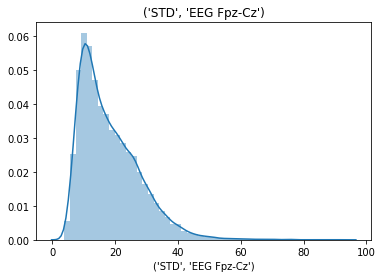

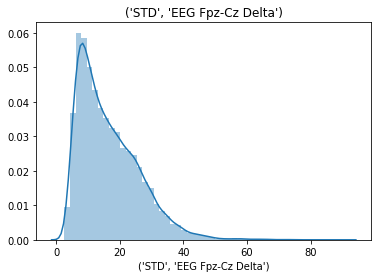

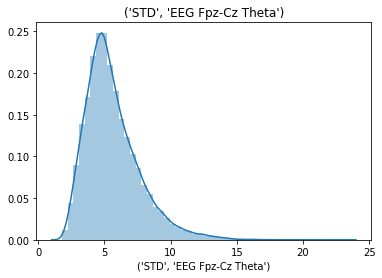

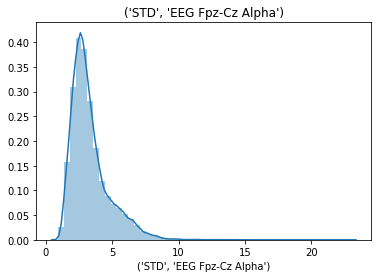

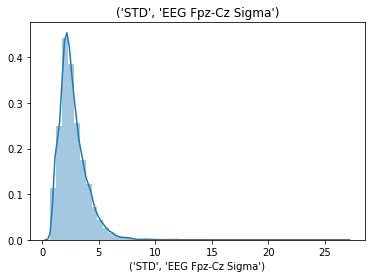

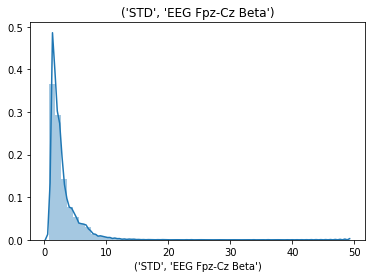

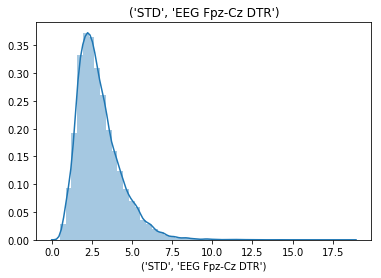

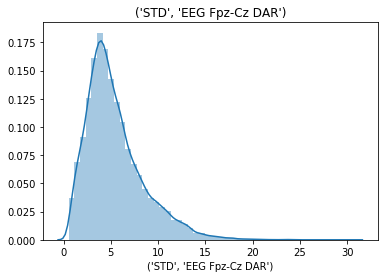

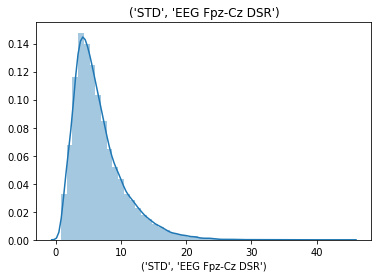

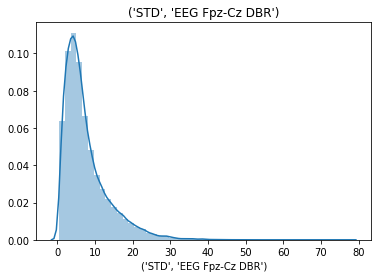

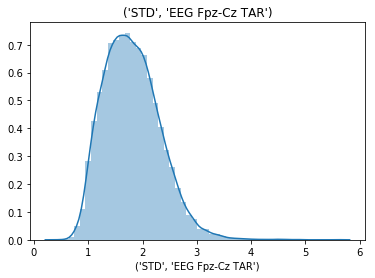

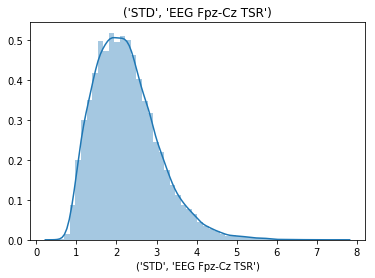

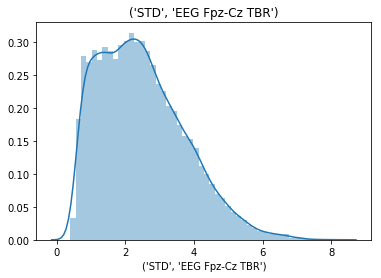

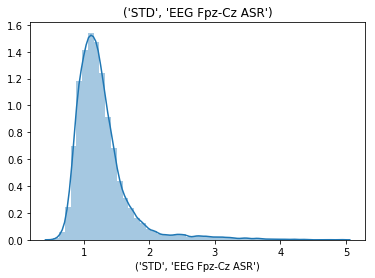

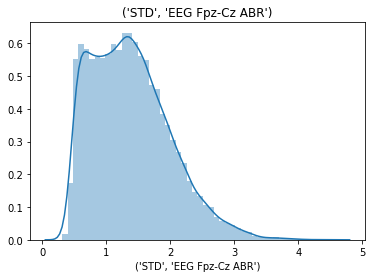

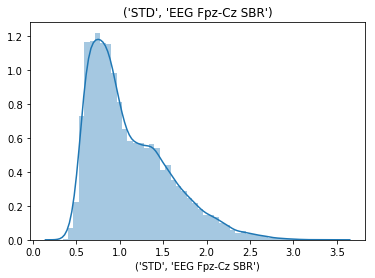

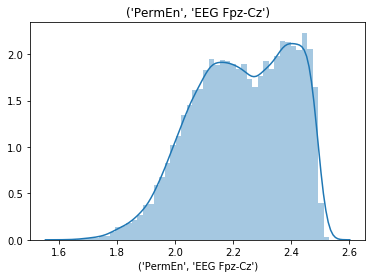

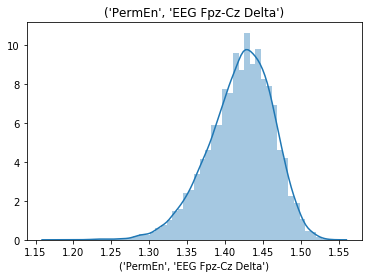

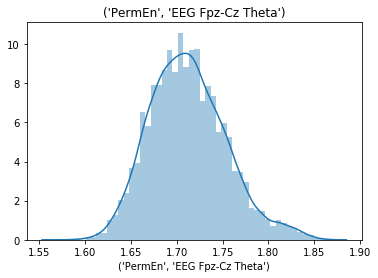

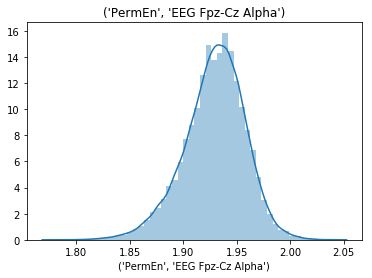

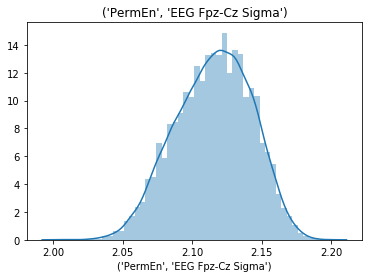

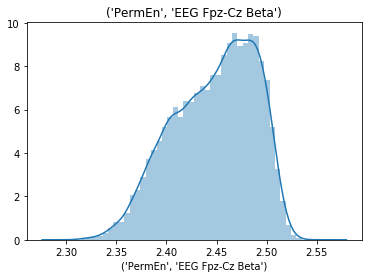

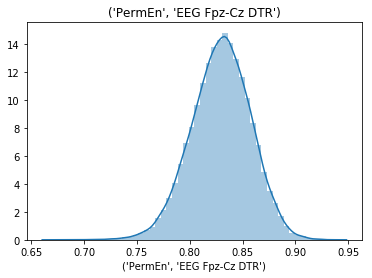

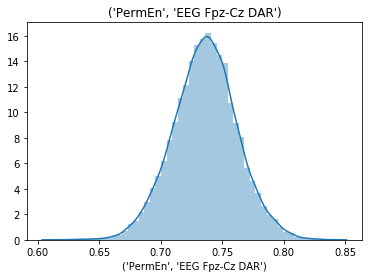

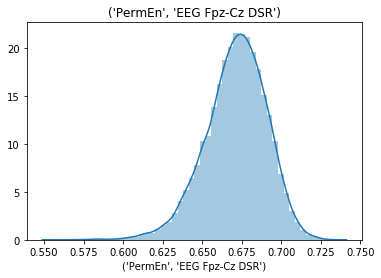

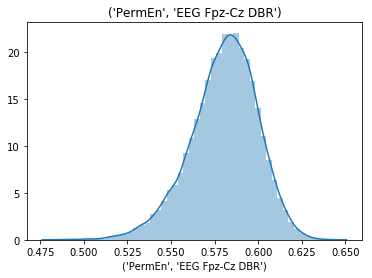

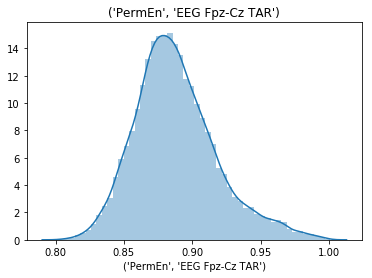

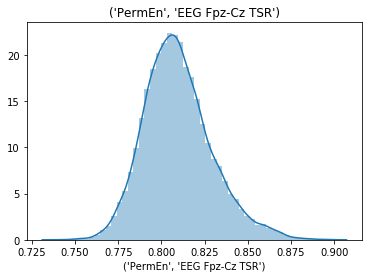

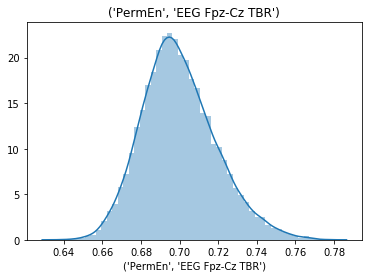

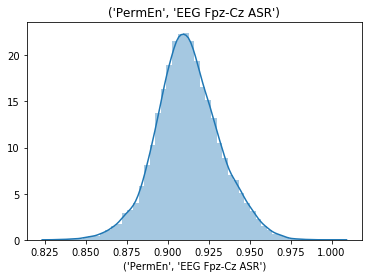

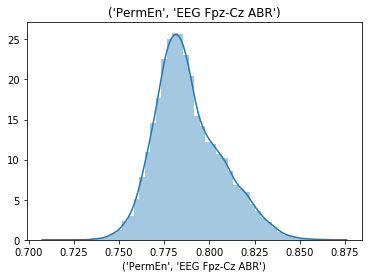

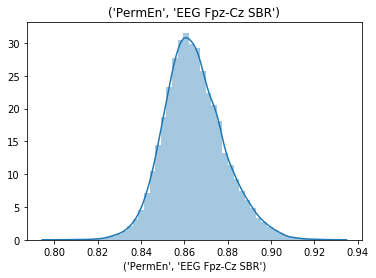

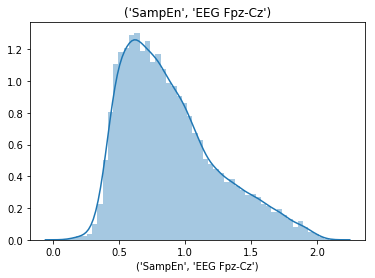

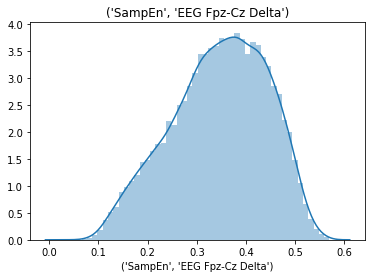

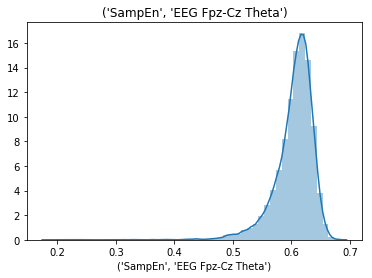

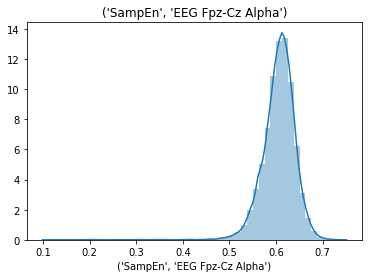

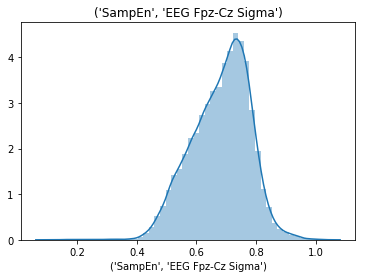

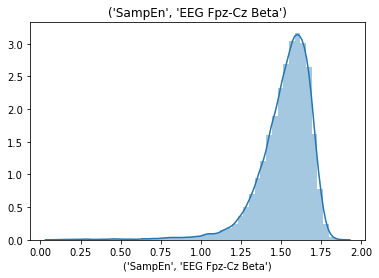

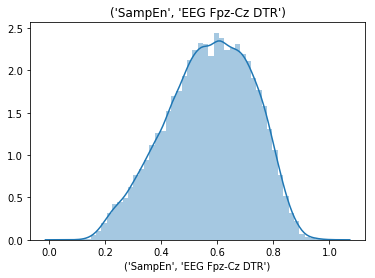

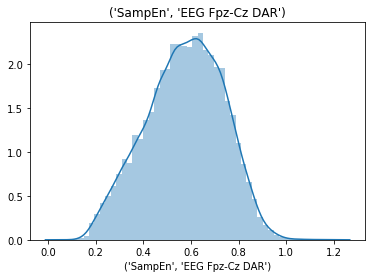

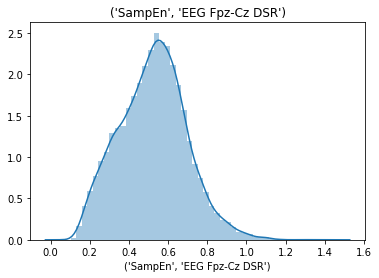

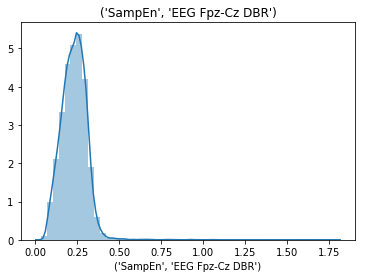

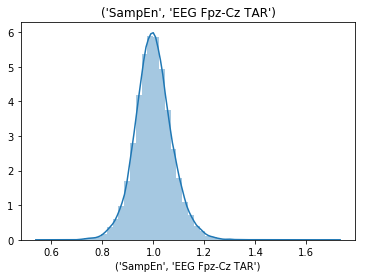

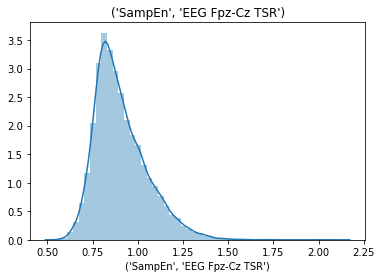

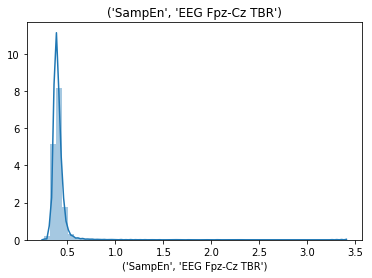

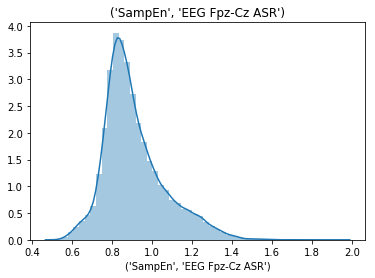

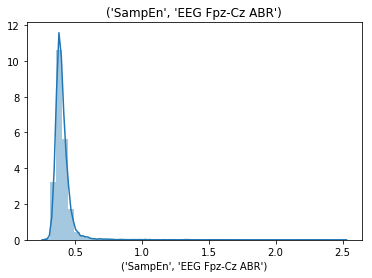

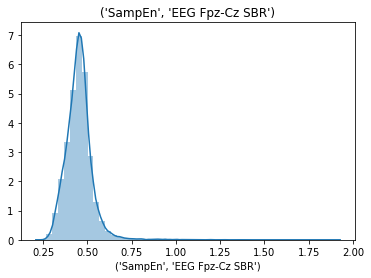

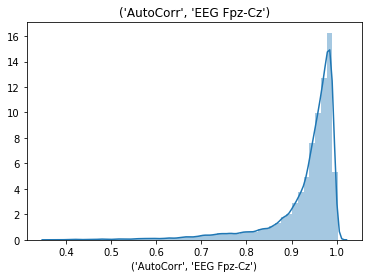

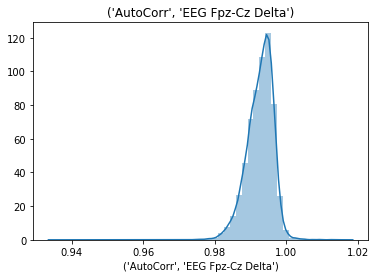

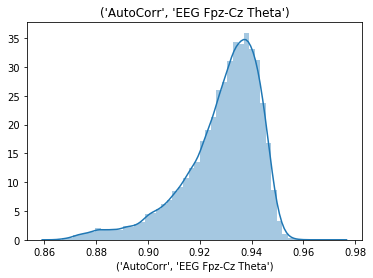

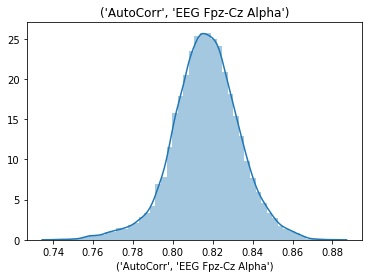

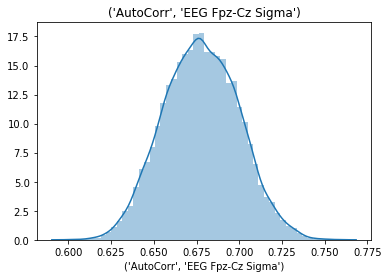

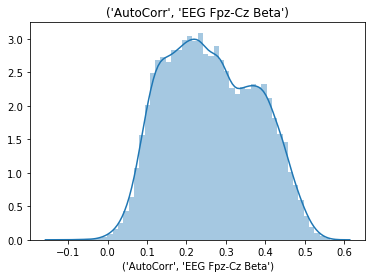

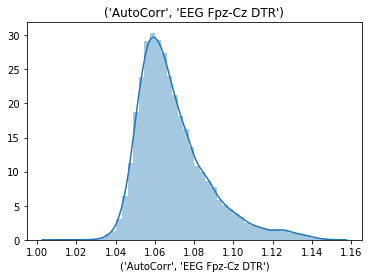

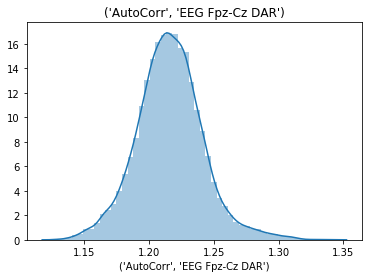

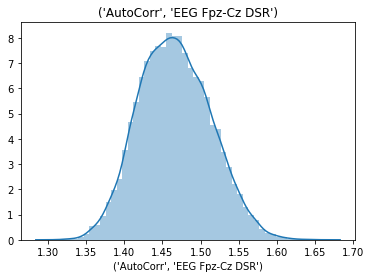

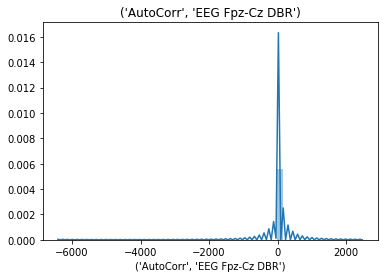

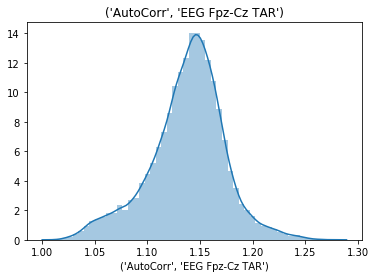

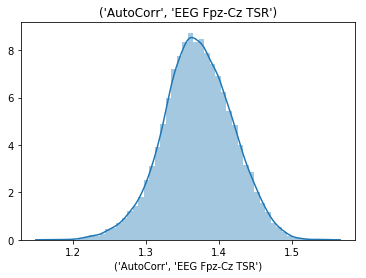

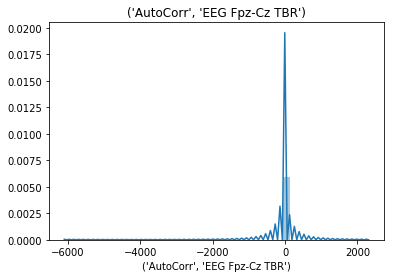

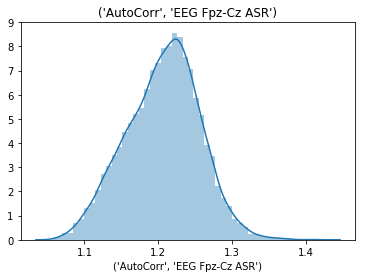

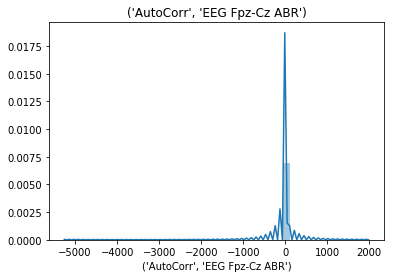

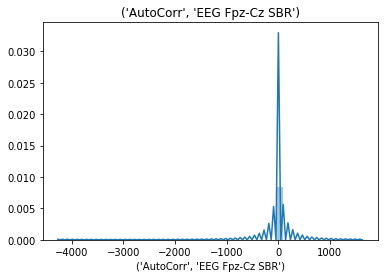

In [34]:
results_dir = 'C:/Users/vita7/OneDrive/Documents/Github/EEG_SleepStage_Analysis/KDE/'

if not os.path.isdir(results_dir): 
    os.makedirs(results_dir)

# Dist + KDE
for col in list(train_X.columns):
    sns.distplot(train_X[col])
    plt.title(col)
    plt.savefig(results_dir + str(col) + '_KDE.png')
    plt.show()

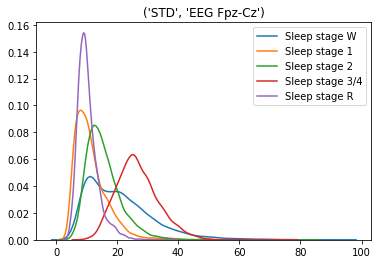

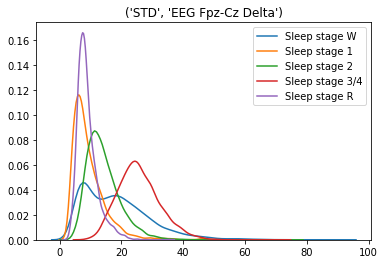

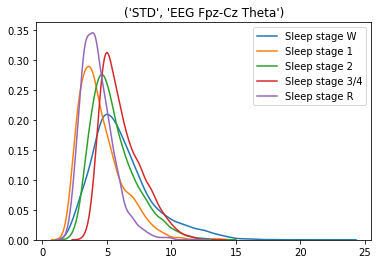

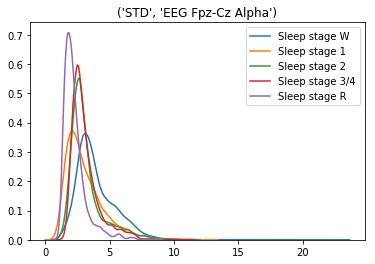

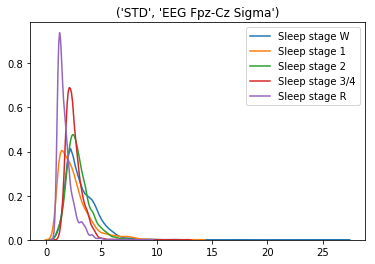

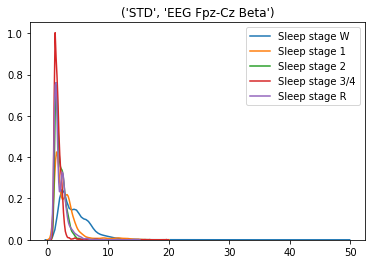

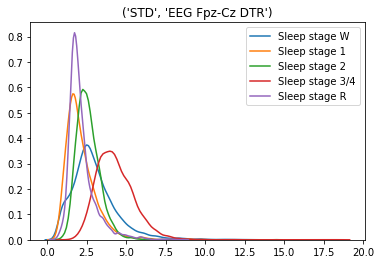

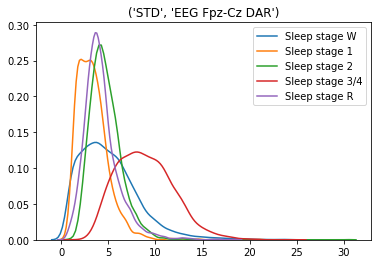

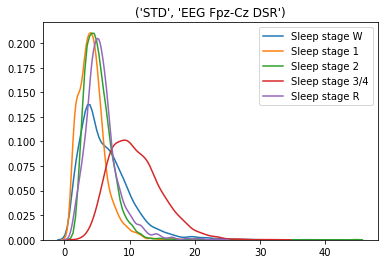

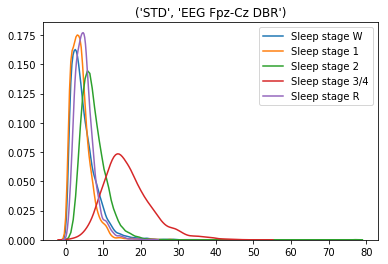

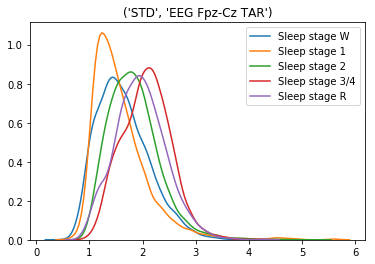

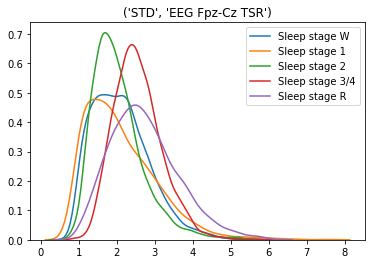

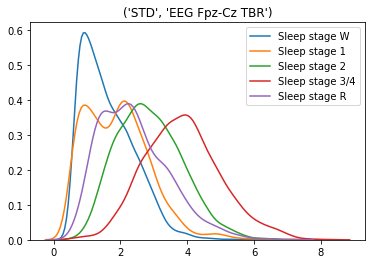

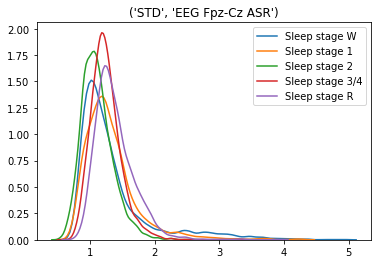

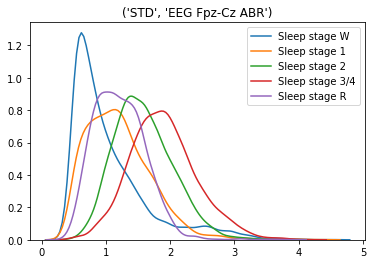

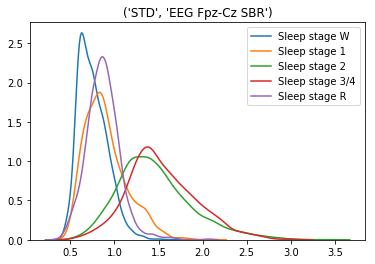

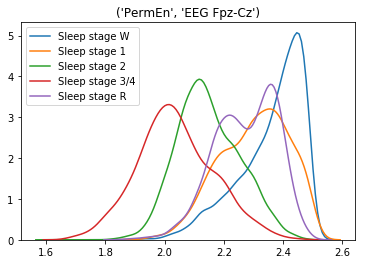

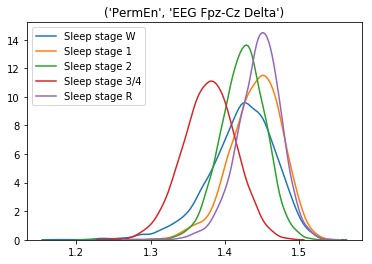

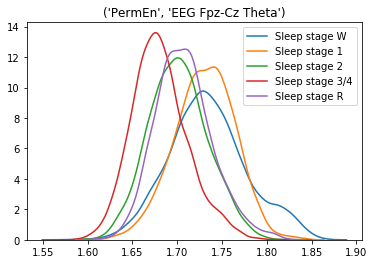

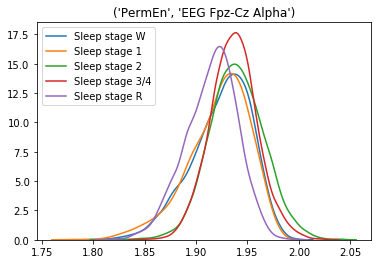

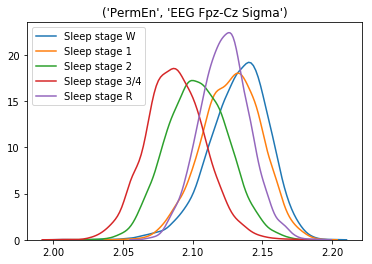

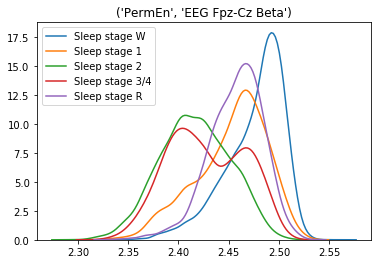

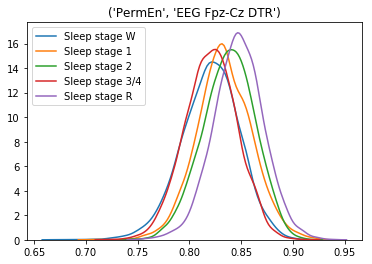

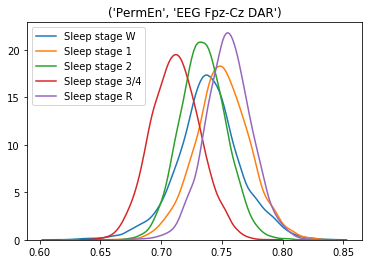

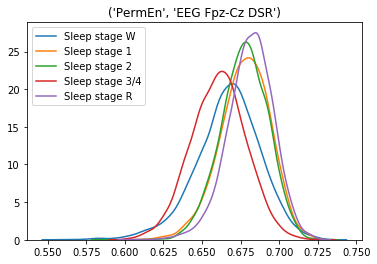

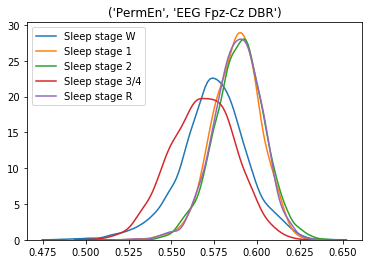

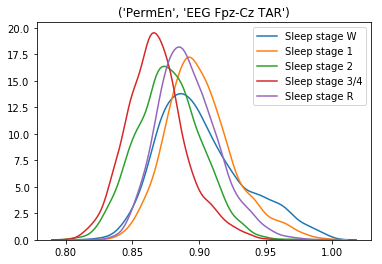

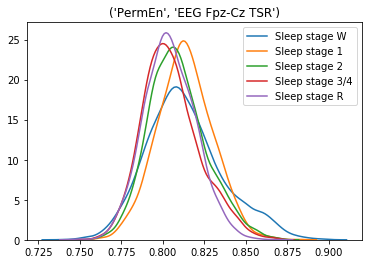

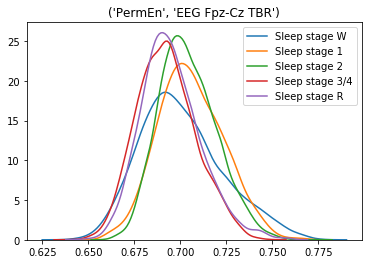

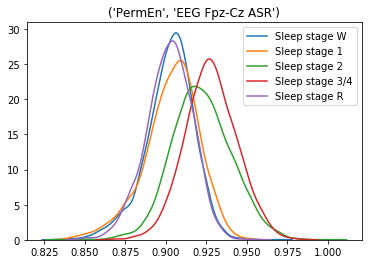

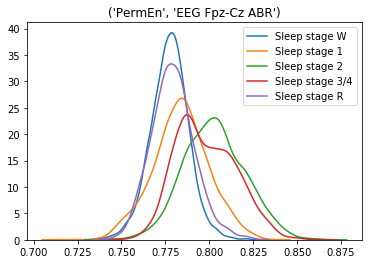

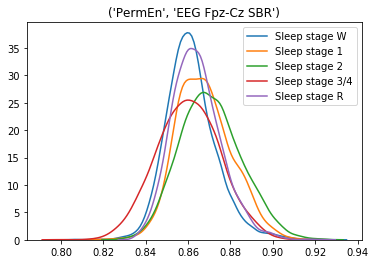

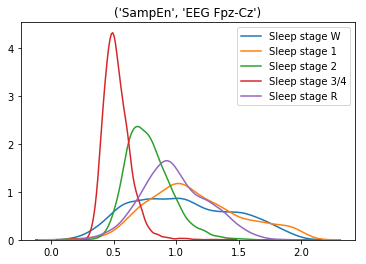

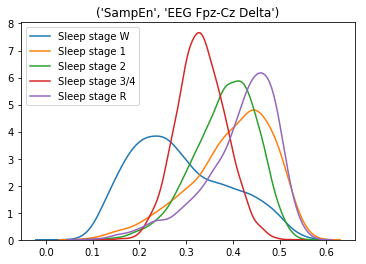

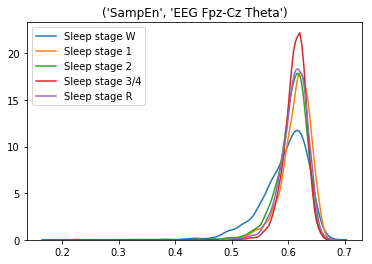

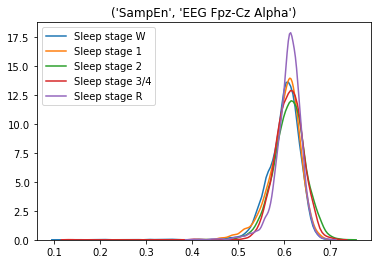

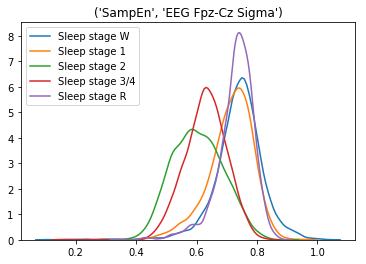

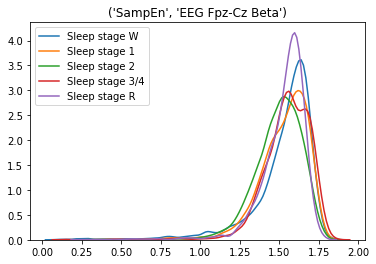

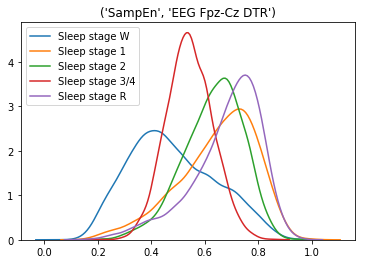

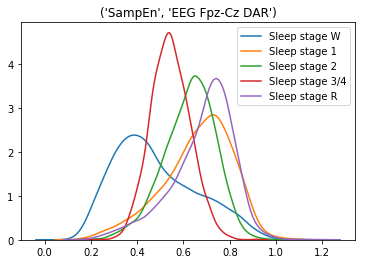

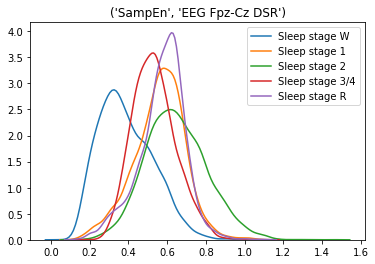

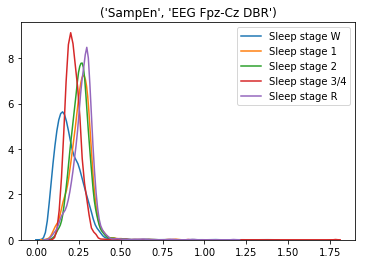

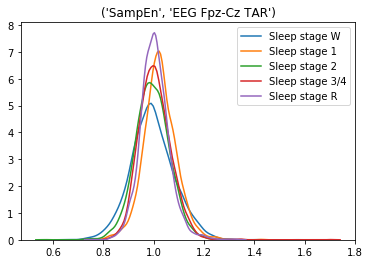

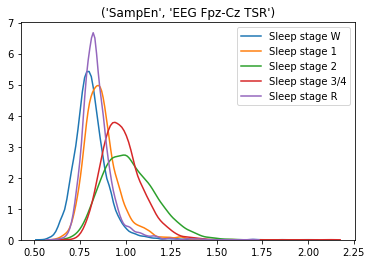

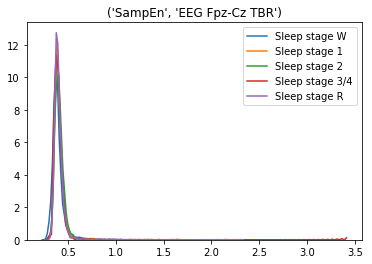

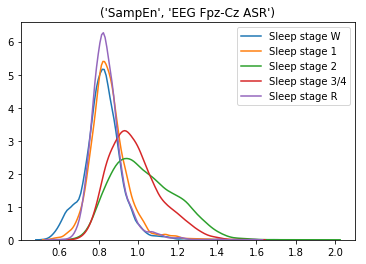

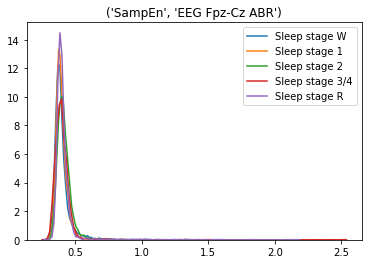

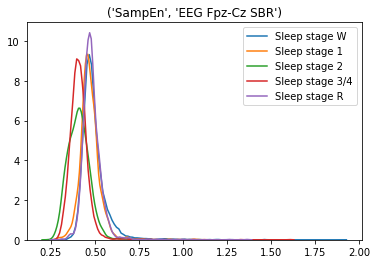

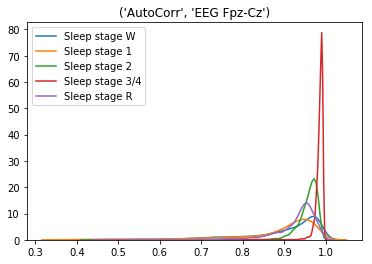

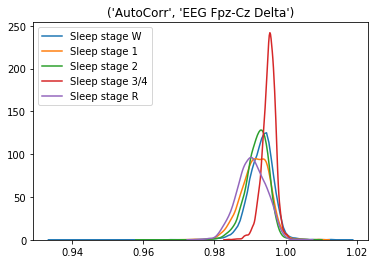

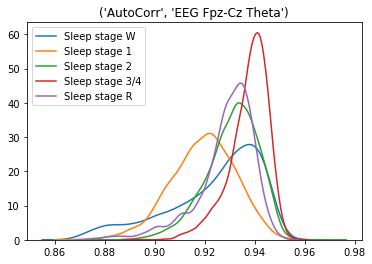

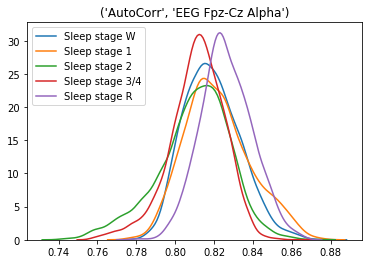

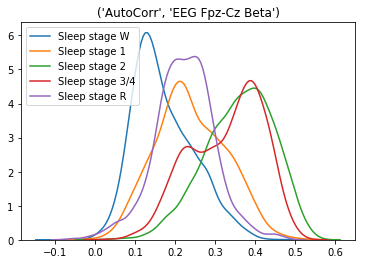

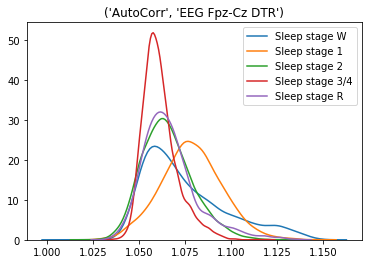

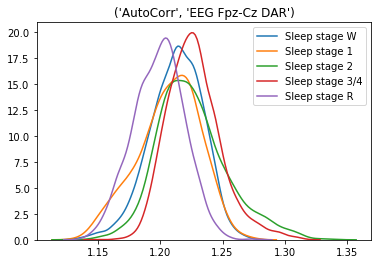

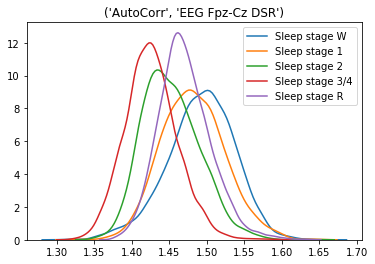

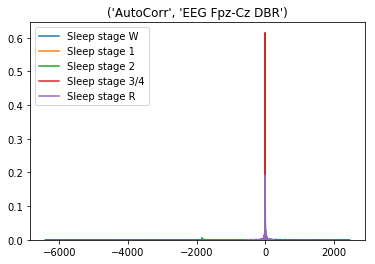

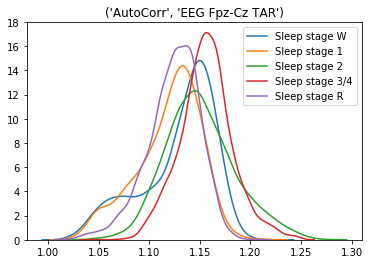

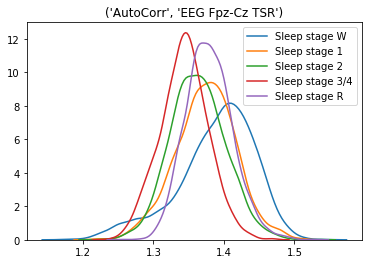

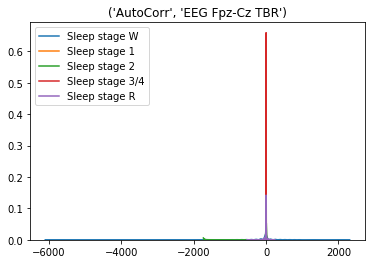

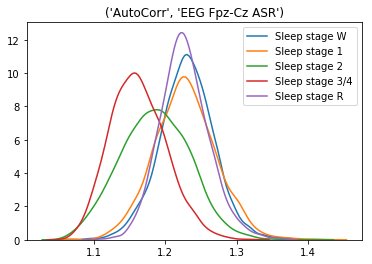

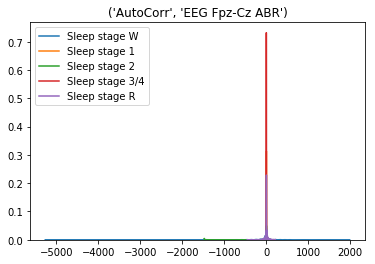

In [35]:
results_dir = 'C:/Users/vita7/OneDrive/Documents/Github/EEG_SleepStage_Analysis/Stage_KDE/'

if not os.path.isdir(results_dir): 
    os.makedirs(results_dir)

for col in list(train_X.columns):
    plt.title(col)
    for stage in list(event_id.keys()):
        sns.kdeplot(df[df['condition'] == stage][col], label=stage)
    plt.savefig(results_dir + str(col) + '_stage_KDE.png')
    plt.show()